# Analyzing outliers from data & Returning Dates

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import numpy as np
import os
import time
from itertools import chain
from IPython.display import display_html


##### ETF Data Clean up ###########

class ETFDataCleanup(object):
    
    def __init__(self):
        pass

    def showNaColumns(self,df):
        s=df.isnull().sum()
        print(s[s>0])
    
    def dropNAColumns(self,df):
        return df.dropna(axis='columns')
    
    def computeDailyReturns(self,df):
        return df.pct_change().dropna()        
    
    
####### Get Data for Constituents of ETF

class ConstituentsData(ETFDataCleanup):
    
    def __init__(self,fileName=None,startdate=None,enddate=None):
        self.fileName=fileName
        self.startdate=startdate
        self.enddate=enddate
        self.constituentdata=[]
        self.constituentcloseDF=[]
        self.tickerdf=[]
        self.changeDF=[]
        self.waDF=[]
    
    def getconstituentdata(self):
        self.tickerdf = pd.read_excel(self.fileName)
        tickers=self.tickerdf['Ticker']
        self.tickerdf.set_index('Ticker',inplace=True)
        self.constituentdata =  web.DataReader(tickers,'yahoo',self.startdate,self.enddate)
        self.constituentcloseDF = self.constituentdata['Close'].iloc[:, :]
        
    def stringWeightsToFloat(self):
        self.tickerdf['Weights']=self.tickerdf['Weights'].apply(lambda x: x.replace('%','')).astype(float)
    
    def findNetAssetValue(self):
        self.waDF=self.changeDF.copy()
        for col in self.changeDF.columns:
            # Divide by 100 for weights percentage eg 23.28%
            self.waDF[col]=self.changeDF[col]*self.tickerdf['Weights'].loc[col]/100
        self.waDF['NAV']=self.waDF.sum(axis=1)

####### Get prices of ETF        
class ETFStockPrices(ETFDataCleanup):
    
    def __init__(self,etfticker=None,startdate=None,enddate=None):
        self.etfticker=etfticker
        self.startdate=startdate
        self.enddate=enddate
        self.etfdata=[]
        self.etfchangeDF=[]

        
    def getETFTickerData(self):
        self.etfdata =  web.DataReader(self.etfticker,'yahoo',self.startdate,self.enddate)
 


class ETFArbitrage(object):

    def __init__(self,etfob,waDF):
        self.navDF=pd.merge(etfob,waDF['NAV'],left_index=True,right_index=True)
        self.navDF['Date']=self.navDF.index
        self.navDF['Close']=self.navDF['Close']*100
        self.navDF['NAV']=self.navDF['NAV']*100
        del self.navDF['Date']
        self.navDF['Mispricing']=(self.navDF['Close']-self.navDF['NAV'])
        self.navDF['Z-Score'] = np.abs(stats.zscore(self.navDF['Mispricing']))
    
    def scatterplot(self):
        plt.scatter(self.navDF['Close'],self.navDF['NAV'])
        
    def scatterplot2(self):
        #change figure size for the plot
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0]=12
        fig_size[1]=6
        plt.rcParams["figure.figsize"]=fig_size

        plt.scatter(self.navDF.index,self.navDF['Mispricing'])
    
    def seaborndist(self):
        sns.distplot(self.navDF['Mispricing'].values, hist=True, kde=True, 
             bins='auto', color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
        


# Load any ETF you want

XLK
Tickers with NA Values
Symbols
NLOK    64
dtype: int64
***************
Check for NA Values again
Series([], dtype: int64)
Symbols         AAPL       ACN      ADBE       ADI       ADP       ADS  \
Date                                                                     
2020-01-17  0.011071  0.001053  0.012624  0.002854  0.011379 -0.009822   
2020-01-21 -0.006777 -0.000239  0.000743 -0.001339 -0.003788 -0.009388   
2020-01-22  0.003570  0.001243  0.000171  0.009304  0.012089 -0.002056   
2020-01-23  0.004816  0.006065  0.004856  0.003654 -0.002804  0.001613   
2020-01-24 -0.002882 -0.010015 -0.001109 -0.027222 -0.003486 -0.039356   
2020-01-27 -0.029405 -0.009685 -0.012722 -0.045590 -0.008295 -0.016294   
2020-01-28  0.028289  0.017865  0.022283  0.018715  0.014567  0.015902   
2020-01-29  0.020932 -0.010845 -0.008375 -0.009448 -0.040718  0.021988   
2020-01-30 -0.001449  0.001971  0.014446 -0.007595  0.023211 -0.022883   
2020-01-31 -0.044339 -0.015165 -0.015698 -0.023316 -0.020685

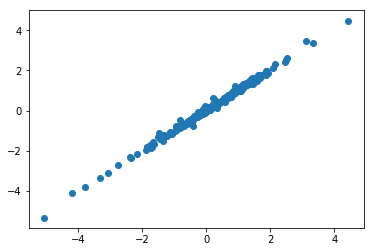

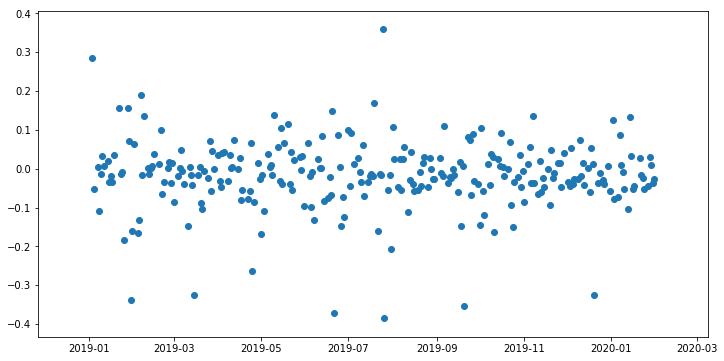

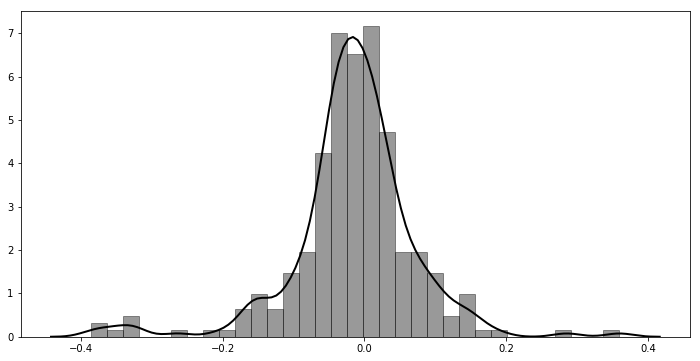

In [2]:
tickeretf="XLK"

filename='ETFDailyData'+'/'+dt.datetime.now().strftime("%Y%m%d")+'/'+tickeretf+'.xls'
startdate=dt.datetime(2019,1,1)
enddate=dt.datetime.today()

ob=ConstituentsData(fileName=filename,startdate=startdate,enddate=enddate)
ob.getconstituentdata()
print(tickeretf)
print("Tickers with NA Values")
ob.showNaColumns(ob.constituentcloseDF)
ob.constituentcloseDF=ob.dropNAColumns(ob.constituentcloseDF)
print("***************")
print("Check for NA Values again")
ob.showNaColumns(ob.constituentcloseDF)
ob.changeDF=ob.computeDailyReturns(ob.constituentcloseDF)
print(ob.changeDF.tail(10))


ob.stringWeightsToFloat()
ob.findNetAssetValue()

print("***************")
print("Data for Constituents")
print(ob.waDF.head(5))

etfob=ETFStockPrices(etfticker=tickeretf,startdate=startdate,enddate=enddate)
etfob.getETFTickerData()
print("Show Any Empty Values")
etfob.showNaColumns(etfob.etfdata)
etfob.etfchangeDF=etfob.computeDailyReturns(etfob.etfdata['Close'])


print("***************")
print("Data for ETF stock prices")
print(etfob.etfchangeDF.head(5))

print("****************")
print("Charts")
arbob=ETFArbitrage(etfob.etfchangeDF,ob.waDF)
arbob.scatterplot()
plt.show()
arbob.scatterplot2()
plt.show()
arbob.seaborndist()
plt.show()



# List down all objects of 3 different classes

In [3]:
print("Constituents Data Objects")
print(dir(ob))

print("*************************")
print("ETF Price Object")
print(dir(etfob))

print("*************************")
print("Arbitrage Data Object")
print(dir(arbob))

Constituents Data Objects
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'changeDF', 'computeDailyReturns', 'constituentcloseDF', 'constituentdata', 'dropNAColumns', 'enddate', 'fileName', 'findNetAssetValue', 'getconstituentdata', 'showNaColumns', 'startdate', 'stringWeightsToFloat', 'tickerdf', 'waDF']
*************************
ETF Price Object
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compute

## arbob.navDF is the ETF arbitrage dataframe which tells about 
1) Daily Return of ETF<br>
2) NET Asset Value of ETF<br>
3) Mispricing <br>
4) Stocks which moved XLK ETF the most<br>

In [4]:
print(arbob.navDF.head(5))

               Close       NAV  Mispricing   Z-Score
Date                                                
2019-01-03 -5.046761 -5.332298    0.285538  3.413520
2019-01-04  4.431993  4.483521   -0.051528  0.407337
2019-01-07  0.894308  0.888819    0.005489  0.238989
2019-01-08  0.838035  0.947695   -0.109661  1.066309
2019-01-09  1.294552  1.307292   -0.012740  0.032356


# Show me days with Arbitrage Opportunities of greater than 3 Standard Deviation

In [5]:
stdthresold=2.5

daysofarbitrage=arbob.navDF[arbob.navDF['Z-Score']>stdthresold]
daysofarbitrage

,Close,NAV,Mispricing,Z-Score
Date,,,,
2019-01-03,-5.046761,-5.332298,0.285538,3.413520
2019-01-30,3.108003,3.445198,-0.337195,3.645558
2019-03-15,0.884588,1.208344,-0.323756,3.493221
2019-04-25,-0.025351,0.238326,-0.263677,2.812178
2019-06-21,-0.823204,-0.452432,-0.370772,4.026171
2019-07-25,-0.410872,-0.770824,0.359952,4.257056
2019-07-26,0.218411,0.603646,-0.385235,4.190124
2019-09-20,-1.473112,-1.119511,-0.353601,3.831529
2019-12-20,0.253523,0.577255,-0.323732,3.492949


## Stocks Returns, Volume & Volume Weighted Returns Standard Deviation

In [6]:
# Good Function
class ZscoreAnlysByAttr():

    def __init__(self,data,zthresh,colname):
        self.data=data
        self.data.name=self.data.name+' '+colname
        self.zthresh=zthresh
        
    def getMispricedData(self):
        self.df=self.data.to_frame()
        self.df['Z-Score']=np.abs(stats.zscore(self.df.values.tolist()))
        self.requiredDF=self.df[self.df['Z-Score']>self.zthresh]
        return self.requiredDF

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [7]:
ticker ='AAPL'
weightedMovement=ob.changeDF[ticker]*ob.constituentdata['Volume'][ticker]
weightedMovement=weightedMovement.dropna()

stockVolumeStd=ZscoreAnlysByAttr(ob.constituentdata['Volume'][ticker],stdthresold,'Volume').getMispricedData()
stockReturnStd=ZscoreAnlysByAttr(ob.changeDF[ticker]*100,stdthresold,'Return').getMispricedData()
stockweightedmovement=ZscoreAnlysByAttr(weightedMovement,stdthresold,'Volume Weighted Return').getMispricedData()

In [8]:
display_side_by_side(stockVolumeStd,stockReturnStd,stockweightedmovement)

,AAPL Volume,Z-Score
Date,,
2019-01-03,91312200.0,5.842951
2019-01-04,58607100.0,2.797687
2019-01-30,61109800.0,3.030721
2019-05-01,64827300.0,3.376868
2019-05-13,57430600.0,2.688140
2019-07-31,69281400.0,3.791601
2019-09-20,55413100.0,2.500285
2019-12-20,68994500.0,3.764887
,AAPL Return,Z-Score


In [9]:
daysofarbitrage

,Close,NAV,Mispricing,Z-Score
Date,,,,
2019-01-03,-5.046761,-5.332298,0.285538,3.413520
2019-01-30,3.108003,3.445198,-0.337195,3.645558
2019-03-15,0.884588,1.208344,-0.323756,3.493221
2019-04-25,-0.025351,0.238326,-0.263677,2.812178
2019-06-21,-0.823204,-0.452432,-0.370772,4.026171
2019-07-25,-0.410872,-0.770824,0.359952,4.257056
2019-07-26,0.218411,0.603646,-0.385235,4.190124
2019-09-20,-1.473112,-1.119511,-0.353601,3.831529
2019-12-20,0.253523,0.577255,-0.323732,3.492949


In [10]:
d=[list(daysofarbitrage.index),list(stockVolumeStd.index),list(stockReturnStd.index),list(stockweightedmovement.index)]
#d=[list(stockReturnStd.index),list(daysofarbitrage.index)]
set.intersection(*map(set,d))

{Timestamp('2019-01-03 00:00:00'), Timestamp('2019-01-30 00:00:00')}

### Find Intersection of Dates where values were > 3 std <br>
 1) daysofarbitrage - When ETF Gave 3 STD away Returns<br>
 2) stockVolumeStd - When Volume was 3 std away from normal day for Stock<br>
 3) stockReturnStd - When Daily Returns were 3 srd away from normal days<br>
 4) stockweightedmovement - When Daily Returns * Volume were 3 Stanadrd Deviation Away<br>

### Finding Dates for Mispricing Due to any of all Tickers

In [11]:
tickers=ob.constituentcloseDF.columns
DF=pd.DataFrame()
kvpairs={}
#MispriceDF.set_index('Ticker',inplace=True)
for ticker in tickers:
    weightedMovement=ob.changeDF[ticker]*ob.constituentdata['Volume'][ticker]
    weightedMovement=weightedMovement.dropna()
    stockVolumeStd=ZscoreAnlysByAttr(ob.constituentdata['Volume'][ticker],stdthresold,'Volume').getMispricedData()
    stockReturnStd=ZscoreAnlysByAttr(ob.changeDF[ticker]*100,stdthresold,'Return').getMispricedData()
    stockweightedmovement=ZscoreAnlysByAttr(weightedMovement,stdthresold,'Volume Weighted Return').getMispricedData()
    #d=[list(daysofarbitrage.index),list(stockVolumeStd.index),list(stockReturnStd.index),list(stockweightedmovement.index)]
    d=[list(daysofarbitrage.index),list(stockweightedmovement.index)]
    lst=(list(set.intersection(*map(set,d))))
    if len(lst)>0:
        kvpairs[ticker]=lst
#kvpairs
MispriceDF=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kvpairs.items() ]))
print(MispriceDF)

        AAPL        ACN       ADBE        ADI        ADP       AKAM  \
0 2019-01-30 2019-01-03 2019-03-15 2019-01-03 2019-01-30 2019-12-20   
1 2019-01-03        NaT        NaT        NaT 2019-01-03        NaT   
2        NaT        NaT        NaT        NaT        NaT        NaT   

        AMAT        AMD       ANSS        APH  ...        NOW       PYPL  \
0 2019-01-03 2019-01-30 2019-01-03 2019-01-03  ... 2019-04-25 2019-07-25   
1        NaT 2019-01-03 2019-12-20        NaT  ...        NaT        NaT   
2        NaT        NaT        NaT        NaT  ...        NaT        NaT   

         STX       SWKS        TEL        TXN          V       VRSN  \
0 2019-01-03 2019-01-03 2019-01-03 2019-01-03 2019-01-03 2019-01-03   
1        NaT        NaT        NaT 2019-03-15        NaT        NaT   
2        NaT        NaT        NaT        NaT        NaT        NaT   

        XLNX        XRX  
0 2019-04-25 2019-01-30  
1        NaT        NaT  
2        NaT        NaT  

[3 rows x 33 columns

In [19]:
kvpairs

{'AAPL': [Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-03 00:00:00')],
 'ACN': [Timestamp('2019-01-03 00:00:00')],
 'ADBE': [Timestamp('2019-03-15 00:00:00')],
 'ADI': [Timestamp('2019-01-03 00:00:00')],
 'ADP': [Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-03 00:00:00')],
 'AKAM': [Timestamp('2019-12-20 00:00:00')],
 'AMAT': [Timestamp('2019-01-03 00:00:00')],
 'AMD': [Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-03 00:00:00')],
 'ANSS': [Timestamp('2019-01-03 00:00:00'), Timestamp('2019-12-20 00:00:00')],
 'APH': [Timestamp('2019-01-03 00:00:00')],
 'AVGO': [Timestamp('2019-01-03 00:00:00'), Timestamp('2019-03-15 00:00:00')],
 'CDW': [Timestamp('2019-09-20 00:00:00')],
 'CTXS': [Timestamp('2019-07-25 00:00:00')],
 'FFIV': [Timestamp('2019-07-26 00:00:00'), Timestamp('2019-12-20 00:00:00')],
 'FISV': [Timestamp('2019-07-26 00:00:00')],
 'FLIR': [Timestamp('2019-04-25 00:00:00'), Timestamp('2019-07-25 00:00:00')],
 'GLW': [Timestamp('2019-01-03 00:00:00')],
 'JN

### Dropping Tickers with all NA values

In [12]:
MispriceDF=MispriceDF.T
MispriceDF

,0,1,2
AAPL,2019-01-30,2019-01-03,NaT
ACN,2019-01-03,NaT,NaT
ADBE,2019-03-15,NaT,NaT
ADI,2019-01-03,NaT,NaT
ADP,2019-01-30,2019-01-03,NaT
AKAM,2019-12-20,NaT,NaT
AMAT,2019-01-03,NaT,NaT
AMD,2019-01-30,2019-01-03,NaT
ANSS,2019-01-03,2019-12-20,NaT
APH,2019-01-03,NaT,NaT


# Adding Stocks which caused miss pricing to dataframe 

In [13]:
# Invert a dict
class InvertDict(object):

    def invertdict(self,d):
        newdict = {}
        for key, value in d.items():
            for string in value:
                newdict.setdefault(string, []).append(key)
    
        return newdict

In [14]:
stockscausingmispricing=InvertDict().invertdict(kvpairs)

In [15]:
daysofarbitrage['Stocks Caused Mispricing'] = daysofarbitrage.index.to_series().map(stockscausingmispricing)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
daysofarbitrage

,Close,NAV,Mispricing,Z-Score,Stocks Caused Mispricing
Date,,,,,
2019-01-03,-5.046761,-5.332298,0.285538,3.413520,"[AAPL, ACN, ADI, ADP, AMAT, AMD, ANSS, APH, AV..."
2019-01-30,3.108003,3.445198,-0.337195,3.645558,"[AAPL, ADP, AMD, JNPR, KLAC, MSFT, XRX]"
2019-03-15,0.884588,1.208344,-0.323756,3.493221,"[ADBE, AVGO, MXIM, TXN]"
2019-04-25,-0.025351,0.238326,-0.263677,2.812178,"[FLIR, MSFT, NOW, XLNX]"
2019-06-21,-0.823204,-0.452432,-0.370772,4.026171,NaN
2019-07-25,-0.410872,-0.770824,0.359952,4.257056,"[CTXS, FLIR, PYPL]"
2019-07-26,0.218411,0.603646,-0.385235,4.190124,"[FFIV, FISV]"
2019-09-20,-1.473112,-1.119511,-0.353601,3.831529,[CDW]
2019-12-20,0.253523,0.577255,-0.323732,3.492949,"[AKAM, ANSS, FFIV]"


# Work to be done

In [ ]:
1) In daysofarbitrage dataframe change 'close' to 'Etf Return' 
2) In daysofarbitrage dataframe add a 'close' column for ETF closing price. It's important to see daily price.
3) https://etfdb.com/etfs/sector/healthcare/